In [2]:
!pip install awswrangler

In [19]:
!pip install pyathena

In [20]:
from pyathena import connect

# Basic connection test
def test_basic_query():
    try:
        conn = connect(
            s3_staging_dir='s3://yelp-raw-data/athena-results/',
            region_name='us-east-1'
        )
        
        cursor = conn.cursor()
        
        # Simple test query
        cursor.execute("SELECT 1")
        result = cursor.fetchone()
        print("Basic query successful!")
        print(f"Result: {result}")
        
        return True
    except Exception as e:
        print(f"Connection error: {str(e)}")
        return False

# Test the connection
test_basic_query()

Basic query successful!
Result: (1,)


True

In [22]:
from pyathena import connect
import pandas as pd

# Connect to Athena
conn = connect(
    s3_staging_dir='s3://yelp-raw-data/athena-results/',
    region_name='us-east-1',
    schema_name='yelp_db'  # Explicitly set the database/schema name
)

def explore_yelp_data():
    try:
        # Create a cursor
        cursor = conn.cursor()
        
        # First, let's verify we can see the tables
        print("Available tables in yelp_db:")
        cursor.execute("""
        SELECT table_name 
        FROM information_schema.tables 
        WHERE table_schema = 'yelp_db'
        """)
        tables = cursor.fetchall()
        for table in tables:
            print(f"- {table[0]}")

        # Get sample from business table
        print("\nFetching sample from business table:")
        cursor.execute("""
        SELECT *
        FROM yelp_db.business
        LIMIT 5
        """)
        
        # Convert to DataFrame
        columns = [desc[0] for desc in cursor.description]
        rows = cursor.fetchall()
        df = pd.DataFrame(rows, columns=columns)
        
        print("\nSample data:")
        print(df)
        
        return True
    except Exception as e:
        print(f"Error: {str(e)}")
        return False

# Run the exploration
explore_yelp_data()

Available tables in yelp_db:
- business
- reviews
- tips

Fetching sample from business table:

Sample data:
              business_id                       name  \
0  --OS_I7dnABrXvRCCuWOGQ  Lens Auto Body & Painting   
1  -0H_3r6z2giieA6oSTUFKQ               Jos. A. Bank   
2  -0__F9fnKt8uioCKztF5Ww                   Piscobar   
3  -1dARtemb2Gy7XlftvtNXQ        New Hope Pet Center   
4  -3-6BB10tIWNKGEF0Es2BA      The 81 Hong Kong Cafe   

                           address          city state postal_code   latitude  \
0                 4819 Cottman Ave  Philadelphia    PA       19135  40.028160   
1  27001 US Highway 19 N, Ste 2010    Clearwater    FL       33761  28.017561   
2                     914 Union St   New Orleans    LA       70112  29.951696   
3                   12 Village Row      New Hope    PA       18938  40.387747   
4        625 E Wetmore Rd, Ste 109        Tucson    AZ       85705  32.288540   

    longitude  stars  review_count  is_open  \
0  -75.033803    4.0

True

# Reservoir Sampling

Starting reservoir sampling...
Fetching reviews...
Processing reviews...
Processed 10000 reviews...
Processed 20000 reviews...
Processed 30000 reviews...
Processed 40000 reviews...
Processed 50000 reviews...
Processed 60000 reviews...
Processed 70000 reviews...
Processed 80000 reviews...
Processed 90000 reviews...
Processed 100000 reviews...
Processed 110000 reviews...
Processed 120000 reviews...
Processed 130000 reviews...
Processed 140000 reviews...
Processed 150000 reviews...
Processed 160000 reviews...
Processed 170000 reviews...
Processed 180000 reviews...
Processed 190000 reviews...
Processed 200000 reviews...
Processed 210000 reviews...
Processed 220000 reviews...
Processed 230000 reviews...
Processed 240000 reviews...
Processed 250000 reviews...
Processed 260000 reviews...
Processed 270000 reviews...
Processed 280000 reviews...
Processed 290000 reviews...
Processed 300000 reviews...
Processed 310000 reviews...
Processed 320000 reviews...
Processed 330000 reviews...
Processed 34

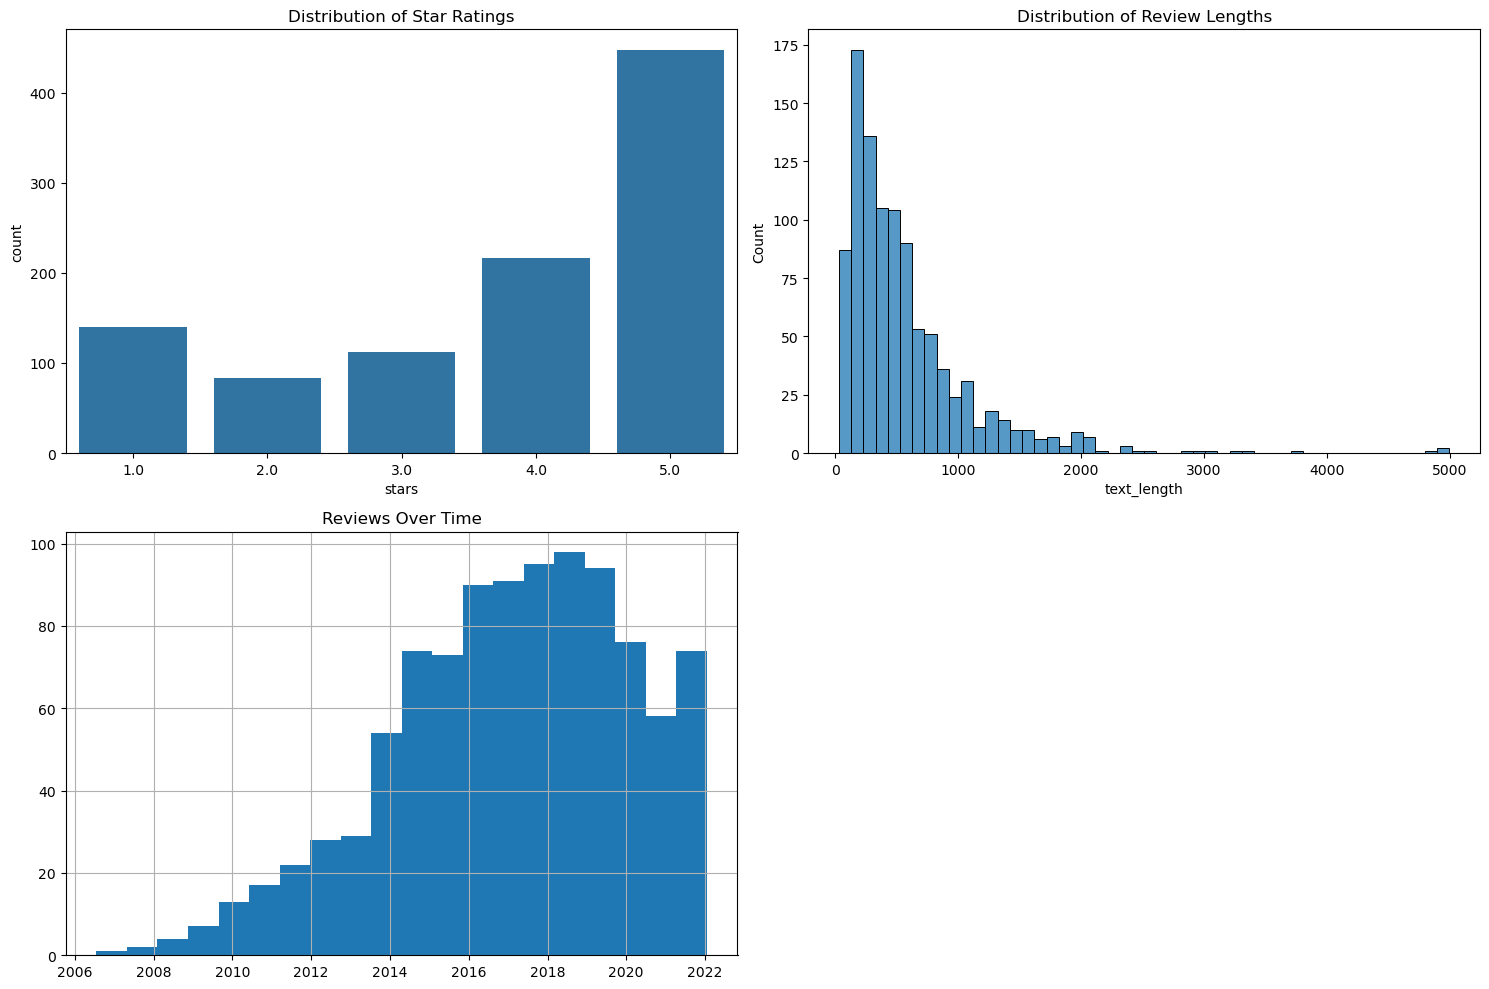

In [26]:
from pyathena import connect
import pandas as pd
import numpy as np
from tqdm import tqdm

# Your existing connection
conn = connect(
    s3_staging_dir='s3://yelp-raw-data/athena-results/',
    region_name='us-east-1',
    schema_name='yelp_db'
)

class ReservoirSampling:
    def __init__(self, sample_size=1000):
        self.sample_size = sample_size
        self.reservoir = []
        self.count = 0
    
    def add(self, item):
        self.count += 1
        if len(self.reservoir) < self.sample_size:
            self.reservoir.append(item)
        else:
            # Randomly decide whether to replace an item
            j = np.random.randint(0, self.count)
            if j < self.sample_size:
                self.reservoir[j] = item

def sample_reviews(sample_size=1000):
    try:
        cursor = conn.cursor()
        
        # Get all reviews with a random order
        print("Fetching reviews...")
        query = """
        SELECT review_id, business_id, user_id, stars, date, text
        FROM yelp_db.reviews
        ORDER BY RAND() limit 500000
        """
        
        # Initialize reservoir
        reservoir = ReservoirSampling(sample_size)
        
        # Execute query
        cursor.execute(query)
        columns = [desc[0] for desc in cursor.description]
        
        # Process reviews one by one
        print("Processing reviews...")
        count = 0
        while True:
            # Fetch reviews in chunks
            rows = cursor.fetchmany(1000)
            if not rows:
                break
                
            for row in rows:
                review_dict = dict(zip(columns, row))
                reservoir.add(review_dict)
                count += 1
                
                # Print progress every 10000 reviews
                if count % 10000 == 0:
                    print(f"Processed {count} reviews...")
        
        # Convert reservoir to DataFrame
        sampled_df = pd.DataFrame(reservoir.reservoir)
        
        # Save sample to CSV (optional)
        # sampled_df.to_csv('review_sample.csv', index=False)
        # print(f"\nSampling completed. Collected {len(sampled_df)} reviews.")
        
        # Print sample statistics
        print("\nSample Statistics:")
        print(f"Average stars: {sampled_df['stars'].mean():.2f}")
        print("\nStar distribution:")
        print(sampled_df['stars'].value_counts().sort_index())
        
        return sampled_df
    
    except Exception as e:
        print(f"Error in sampling: {str(e)}")
        return None

# Function to analyze sample characteristics
def analyze_sample(sampled_df):
    try:
        print("\nSample Analysis:")
        
        # Time distribution
        sampled_df['date'] = pd.to_datetime(sampled_df['date'])
        print("\nDate range:")
        print(f"Earliest review: {sampled_df['date'].min()}")
        print(f"Latest review: {sampled_df['date'].max()}")
        
        # User distribution
        unique_users = sampled_df['user_id'].nunique()
        print(f"\nUnique users in sample: {unique_users}")
        
        # Business distribution
        unique_businesses = sampled_df['business_id'].nunique()
        print(f"Unique businesses in sample: {unique_businesses}")
        
        # Text length analysis
        sampled_df['text_length'] = sampled_df['text'].str.len()
        print("\nText length statistics:")
        print(sampled_df['text_length'].describe())
        
        # Add visualization
        try:
            import matplotlib.pyplot as plt
            import seaborn as sns
            
            # Create a figure with multiple subplots
            plt.figure(figsize=(15, 10))
            
            # Star distribution
            plt.subplot(2, 2, 1)
            sns.countplot(data=sampled_df, x='stars')
            plt.title('Distribution of Star Ratings')
            
            # Text length distribution
            plt.subplot(2, 2, 2)
            sns.histplot(data=sampled_df, x='text_length', bins=50)
            plt.title('Distribution of Review Lengths')
            
            # Reviews over time
            plt.subplot(2, 2, 3)
            sampled_df['date'].hist(bins=20)
            plt.title('Reviews Over Time')
            
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"Error in visualization: {str(e)}")
        
        return True
        
    except Exception as e:
        print(f"Error in analysis: {str(e)}")
        return False

# Run the sampling and analysis
if __name__ == "__main__":
    print("Starting reservoir sampling...")
    # Sample 1000 reviews
    sampled_reviews = sample_reviews(sample_size=1000)
    
    if sampled_reviews is not None:
        # Analyze the sample
        analyze_sample(sampled_reviews)

In our project, we implemented reservoir sampling to efficiently process and sample from a large Yelp business dataset stored in AWS. Our algorithm fetches data in chunks of 1000 businesses at a time from a pool of up to 500,000 businesses, maintaining a reservoir of fixed size 1000. For each business in every chunk, the algorithm decides whether to include it in the reservoir based on random probability. Basically, each business has a fair chance of being in our final sample regardless of when it appears in the stream. The result is a statistically representative sample of 1000 businesses drawn from a much larger dataset, which we then used for following analysis: 

1. Finds the earliest and latest review dates. 

2. Counts how many unique users and businesses are in the sample. 

3. Measures the length of each review to understand its distribution. 

Visualization: 

1. Star rating distribution. 

2. Length of review text 

3. Review activity over time.

In [27]:
!pip install mmh3

# Bloom Filter

implement the Bloom Filter algorithm next to detect potential duplicate businesses. 

Starting duplicate business detection...
Fetching business data...
Loaded 150346 businesses
Initialized Bloom Filter with:
Size: 1441075 bits
Hash functions: 6

Checking for similar businesses...


100%|██████████| 150346/150346 [00:09<00:00, 15521.17it/s]



Found 551 potential duplicate businesses

Sample of potential duplicates:
              business_id                               name  \
0  7sdXYWXJMN3rXMSV8jjXRA  The Eye Institute Of West Florida   
1  kg8N1PNJM5cJmSkafUZ0Ug             Eden Korean Restaurant   
2  IxKNYZCTMRPnOcb2QLUmLg                    Jack In the Box   
3  w8Bmb4xGD0mnv5o5GRv6_w                      Crust N' Fire   
4  4xaiGq1Skr9JKImzJ8Nypg           American Legion Post 273   

                  address           city state  \
0           1225 W Bay Dr          Largo    FL   
1     1428 Marlton Pike E    Cherry Hill    NJ   
2         1780 Gilsinn Ln         Fenton    MO   
3              175 Rte 70        Medford    NJ   
4  600 American Legion Dr  Madeira Beach    FL   

                                          categories  
0  Optometrists, Ophthalmologists, Health & Medic...  
1                                Korean, Restaurants  
2                               Burgers, Restaurants  
3                  

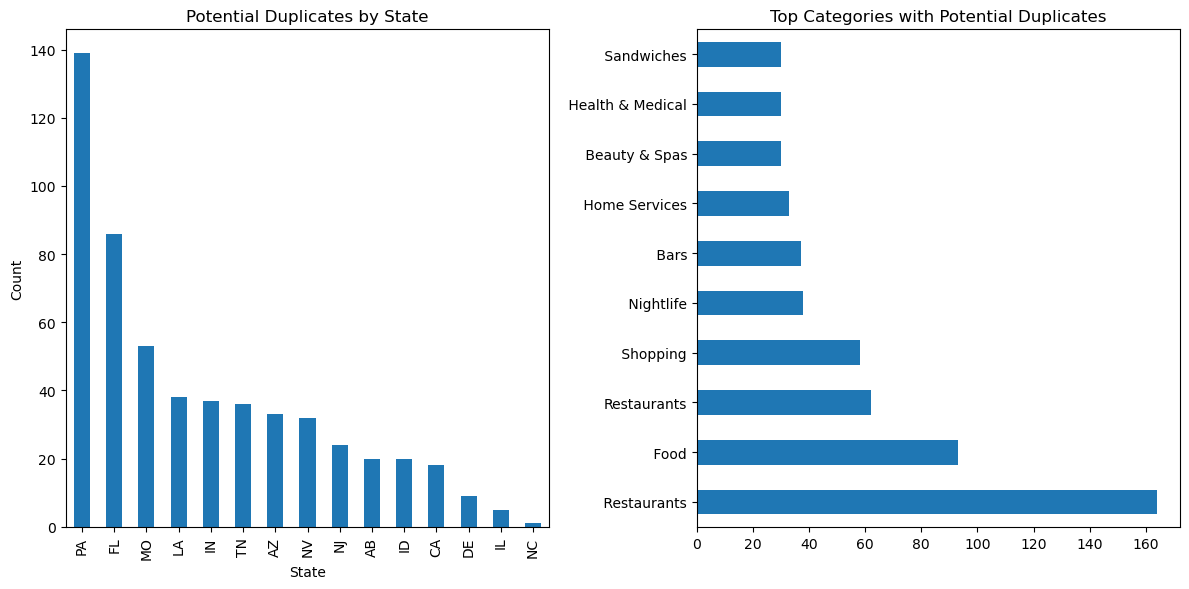

In [30]:
from pyathena import connect
import pandas as pd
import numpy as np
from tqdm import tqdm
import mmh3  # MurmurHash3 for better hash function
import math

# Your existing connection
conn = connect(
    s3_staging_dir='s3://yelp-raw-data/athena-results/',
    region_name='us-east-1',
    schema_name='yelp_db'
)

class BloomFilter:
    def __init__(self, expected_elements, false_positive_rate=0.01):
        # Calculate optimal size and number of hash functions
        self.size = self.get_size(expected_elements, false_positive_rate)
        self.hash_count = self.get_hash_count(self.size, expected_elements)
        self.bit_array = np.zeros(self.size, dtype=bool)
        print(f"Initialized Bloom Filter with:")
        print(f"Size: {self.size} bits")
        print(f"Hash functions: {self.hash_count}")
    
    @staticmethod
    def get_size(n, p):
        """Calculate optimal bit array size"""
        return int(-n * math.log(p) / (math.log(2) ** 2))
    
    @staticmethod
    def get_hash_count(m, n):
        """Calculate optimal number of hash functions"""
        return int(m/n * math.log(2))
    
    def add(self, item):
        """Add an item to the Bloom filter"""
        for seed in range(self.hash_count):
            index = mmh3.hash(str(item), seed) % self.size
            self.bit_array[index] = True
    
    def check(self, item):
        """Check if an item might be in the set"""
        for seed in range(self.hash_count):
            index = mmh3.hash(str(item), seed) % self.size
            if not self.bit_array[index]:
                return False
        return True

def find_similar_businesses(distance_threshold=0.1):
    try:
        cursor = conn.cursor()
        
        # Get business data
        print("Fetching business data...")
        query = """
        SELECT business_id, name, address, city, state, 
               latitude, longitude, categories
        FROM yelp_db.business limit 500000
        """
        
        cursor.execute(query)
        columns = [desc[0] for desc in cursor.description]
        businesses = pd.DataFrame(cursor.fetchall(), columns=columns)
        
        print(f"Loaded {len(businesses)} businesses")
        
        # Initialize Bloom Filter
        bloom = BloomFilter(expected_elements=len(businesses))
        potential_duplicates = []
        
        # Function to create business key
        def create_business_key(row):
            # Normalize business name (remove spaces, lowercase)
            name = row['name'].lower().replace(' ', '')
            # Create location string
            location = f"{row['latitude']:.3f},{row['longitude']:.3f}"
            return f"{name}_{location}"
        
        # Find potential duplicates
        print("\nChecking for similar businesses...")
        for idx, business in tqdm(businesses.iterrows(), total=len(businesses)):
            business_key = create_business_key(business)
            
            if bloom.check(business_key):
                # Found potential duplicate
                potential_duplicates.append({
                    'business_id': business['business_id'],
                    'name': business['name'],
                    'address': business['address'],
                    'city': business['city'],
                    'state': business['state'],
                    'categories': business['categories']
                })
            
            bloom.add(business_key)
        
        # Convert results to DataFrame
        duplicates_df = pd.DataFrame(potential_duplicates)
        
        print(f"\nFound {len(duplicates_df)} potential duplicate businesses")
        
        # Save results
        duplicates_df.to_csv('potential_duplicate_businesses.csv', index=False)
        
        # Analyze results
        if not duplicates_df.empty:
            print("\nSample of potential duplicates:")
            print(duplicates_df.head())
            
            print("\nDuplicate distribution by city:")
            print(duplicates_df['city'].value_counts().head())
            
            # Visualize results
            try:
                import matplotlib.pyplot as plt
                import seaborn as sns
                
                plt.figure(figsize=(12, 6))
                
                # Plot duplicates by state
                plt.subplot(1, 2, 1)
                duplicates_df['state'].value_counts().plot(kind='bar')
                plt.title('Potential Duplicates by State')
                plt.xlabel('State')
                plt.ylabel('Count')
                
                # Plot duplicates by category
                if 'categories' in duplicates_df.columns:
                    plt.subplot(1, 2, 2)
                    # Split categories and get counts
                    all_categories = [cat for cats in duplicates_df['categories'].dropna() 
                                   for cat in str(cats).split(',')]
                    pd.Series(all_categories).value_counts().head(10).plot(kind='barh')
                    plt.title('Top Categories with Potential Duplicates')
                
                plt.tight_layout()
                plt.show()
                
            except Exception as e:
                print(f"Error in visualization: {str(e)}")
        
        return duplicates_df
        
    except Exception as e:
        print(f"Error in finding similar businesses: {str(e)}")
        return None

# Additional function to analyze specific duplicate cases
def analyze_duplicate_pair(business_id1, business_id2):
    try:
        cursor = conn.cursor()
        
        # Get detailed information for both businesses
        query = f"""
        SELECT *
        FROM yelp_db.business
        WHERE business_id IN ('{business_id1}', '{business_id2}')
        """
        
        cursor.execute(query)
        columns = [desc[0] for desc in cursor.description]
        businesses = pd.DataFrame(cursor.fetchall(), columns=columns)
        
        if len(businesses) == 2:
            print("\nComparison of potential duplicates:")
            for col in businesses.columns:
                print(f"\n{col}:")
                print(businesses[col].tolist())
        
        return businesses
        
    except Exception as e:
        print(f"Error in analyzing duplicate pair: {str(e)}")
        return None

# Run the analysis
if __name__ == "__main__":
    print("Starting duplicate business detection...")
    duplicates = find_similar_businesses()
    
    # if duplicates is not None and not duplicates.empty:
    #     # Analyze first pair of duplicates
    #     first_duplicate = duplicates.iloc[0]
    #     print("\nAnalyzing first duplicate in detail:")
    #     analyze_duplicate_pair(first_duplicate['business_id'], 
    #                          duplicates.iloc[1]['business_id'])

We used Bloom filter to detect potential duplicate businesses in our large Yelp dataset. Our implementation processed 150,346 businesses using a bit array of 1,441,075 bits and 6 hash functions to create unique fingerprints of each business based on their name and location coordinates. The Bloom filter successfully identified 551 potential duplicate businesses, with the highest concentration in Philadelphia (77 duplicates), followed by Tucson and New Orleans (32 each).

# DGIM (Discrete Grouping & Improvement Method) 

Implement the DGIM (Discrete Grouping & Improvement Method) algorithm to monitor the streaming review counts over time windows. 

Starting review pattern analysis...
Fetching review data...

Processing reviews...


100%|██████████| 500000/500000 [00:29<00:00, 17034.48it/s]


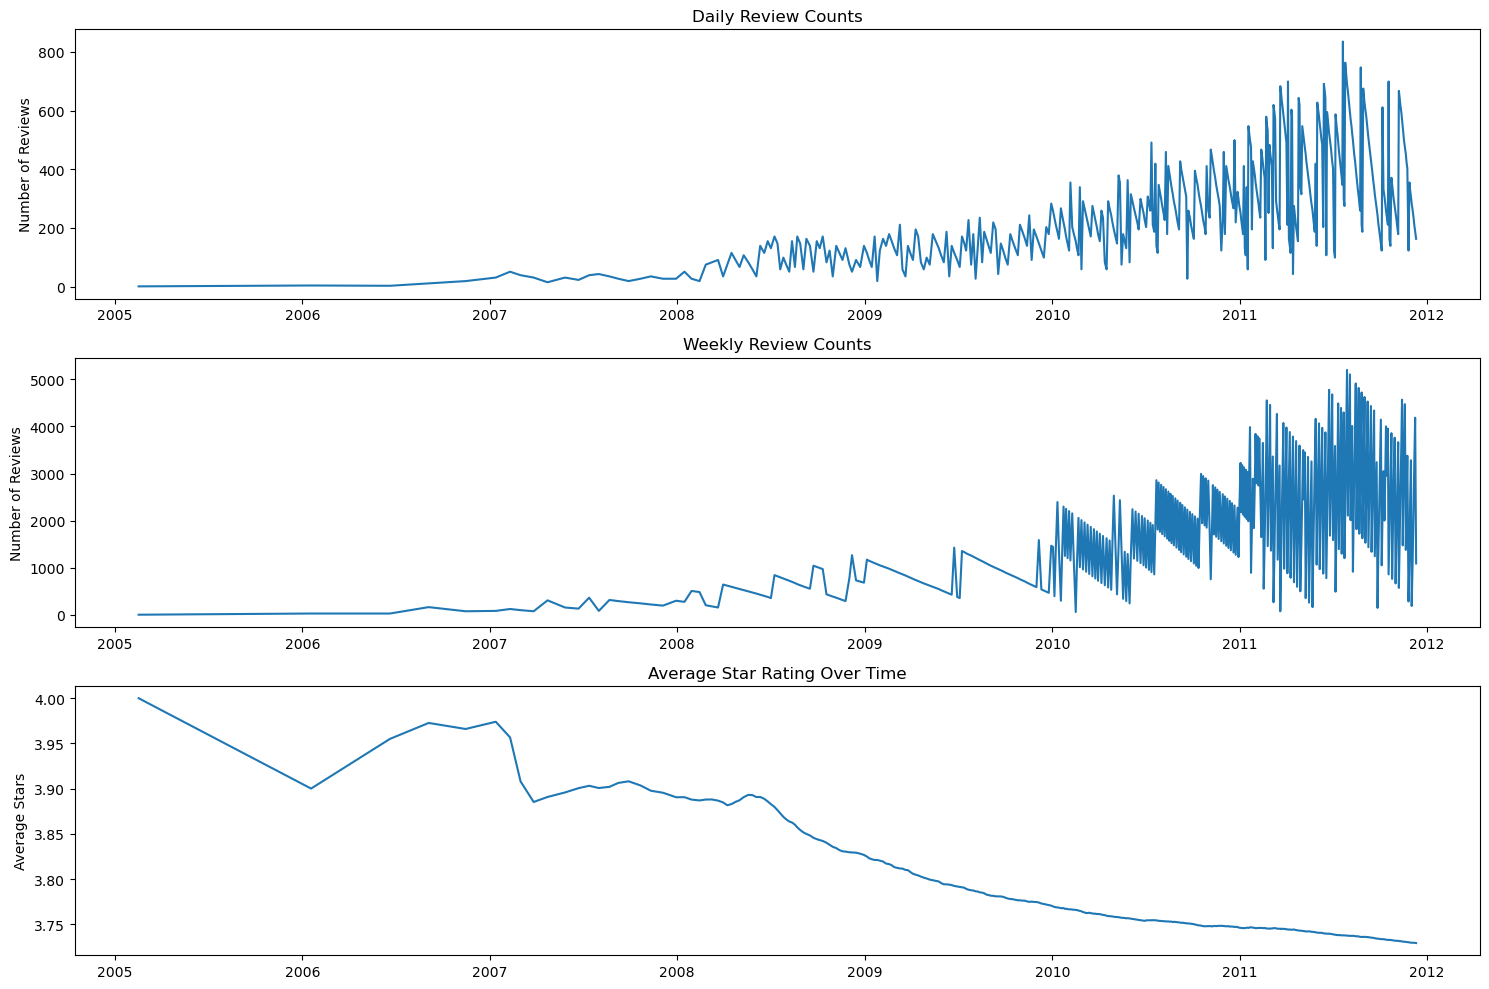


Pattern Analysis:

Peak daily reviews: 835 on 2011-07-21 02:22:56
Peak weekly reviews: 5202 on 2011-07-29 02:57:17

Review growth over period: 108900.00%

Analyzing a specific time period...
Error in analyzing time period: INVALID_CAST_ARGUMENT: Value cannot be cast to date: 2020-01-21 03:42:42


In [32]:
from pyathena import connect
import pandas as pd
import numpy as np
from tqdm import tqdm
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

# Your existing connection
conn = connect(
    s3_staging_dir='s3://yelp-raw-data/athena-results/',
    region_name='us-east-1',
    schema_name='yelp_db'
)

class DGIMBucket:
    def __init__(self, timestamp, size=1):
        self.timestamp = timestamp
        self.size = size

class DGIMCounter:
    def __init__(self, window_size=1000):
        self.window_size = window_size
        self.buckets = []
        self.current_timestamp = 0
        
    def add(self, timestamp, value=1):
        # Remove old buckets outside window
        while self.buckets and (timestamp - self.buckets[0].timestamp) >= self.window_size:
            self.buckets.pop(0)
        
        if value == 1:
            # Add new bucket
            self.buckets.append(DGIMBucket(timestamp))
            self._merge_buckets()
    
    def _merge_buckets(self):
        i = len(self.buckets) - 1
        while i > 0:
            if self.buckets[i].size == self.buckets[i-1].size:
                # Merge buckets of same size
                self.buckets[i-1].size *= 2
                self.buckets.pop(i)
                i -= 1
            i -= 1
    
    def count(self, current_timestamp):
        # Remove buckets outside window
        while self.buckets and (current_timestamp - self.buckets[0].timestamp) >= self.window_size:
            self.buckets.pop(0)
        
        # Sum bucket sizes
        return sum(bucket.size for bucket in self.buckets)

def analyze_review_patterns():
    try:
        cursor = conn.cursor()
        
        # Fetch reviews ordered by date
        print("Fetching review data...")
        query = """
        SELECT date, stars
        FROM yelp_db.reviews
        ORDER BY date limit 500000
        """
        
        cursor.execute(query)
        reviews_df = pd.DataFrame(cursor.fetchall(), columns=['date', 'stars'])
        
        # Convert date strings to timestamps
        reviews_df['date'] = pd.to_datetime(reviews_df['date'])
        
        # Initialize DGIM counters for different windows
        daily_counter = DGIMCounter(window_size=24*60*60)  # 1 day in seconds
        weekly_counter = DGIMCounter(window_size=7*24*60*60)  # 1 week in seconds
        
        # Analysis results
        results = {
            'timestamp': [],
            'daily_count': [],
            'weekly_count': [],
            'avg_stars': []
        }
        
        print("\nProcessing reviews...")
        for idx, row in tqdm(reviews_df.iterrows(), total=len(reviews_df)):
            timestamp = row['date'].timestamp()
            
            # Update counters
            daily_counter.add(timestamp)
            weekly_counter.add(timestamp)
            
            if idx % 1000 == 0:  # Record statistics every 1000 reviews
                results['timestamp'].append(row['date'])
                results['daily_count'].append(daily_counter.count(timestamp))
                results['weekly_count'].append(weekly_counter.count(timestamp))
                results['avg_stars'].append(reviews_df.loc[:idx, 'stars'].mean())
        
        # Convert results to DataFrame
        results_df = pd.DataFrame(results)
        
        # Save results
        # results_df.to_csv('review_patterns.csv', index=False)
        # print("\nResults saved to review_patterns.csv")
        
        # Visualize patterns
        plt.figure(figsize=(15, 10))
        
        # Daily review counts
        plt.subplot(3, 1, 1)
        plt.plot(results_df['timestamp'], results_df['daily_count'])
        plt.title('Daily Review Counts')
        plt.ylabel('Number of Reviews')
        
        # Weekly review counts
        plt.subplot(3, 1, 2)
        plt.plot(results_df['timestamp'], results_df['weekly_count'])
        plt.title('Weekly Review Counts')
        plt.ylabel('Number of Reviews')
        
        # Average stars trend
        plt.subplot(3, 1, 3)
        plt.plot(results_df['timestamp'], results_df['avg_stars'])
        plt.title('Average Star Rating Over Time')
        plt.ylabel('Average Stars')
        
        plt.tight_layout()
        plt.show()
        
        # Additional analysis
        print("\nPattern Analysis:")
        
        # Find peak review periods
        max_daily = results_df.loc[results_df['daily_count'].idxmax()]
        print(f"\nPeak daily reviews: {max_daily['daily_count']} on {max_daily['timestamp']}")
        
        max_weekly = results_df.loc[results_df['weekly_count'].idxmax()]
        print(f"Peak weekly reviews: {max_weekly['weekly_count']} on {max_weekly['timestamp']}")
        
        # Calculate review growth
        first_week = results_df['weekly_count'].iloc[0]
        last_week = results_df['weekly_count'].iloc[-1]
        growth = ((last_week - first_week) / first_week) * 100
        print(f"\nReview growth over period: {growth:.2f}%")
        
        return results_df
        
    except Exception as e:
        print(f"Error in analyzing review patterns: {str(e)}")
        return None

# Function to analyze specific time periods
def analyze_time_period(start_date, end_date):
    try:
        cursor = conn.cursor()
        
        query = f"""
        SELECT DATE(date) as review_date, COUNT(*) as review_count, AVG(stars) as avg_stars
        FROM yelp_db.reviews
        WHERE date BETWEEN '{start_date}' AND '{end_date}'
        GROUP BY DATE(date)
        ORDER BY review_date
        """
        
        cursor.execute(query)
        period_df = pd.DataFrame(cursor.fetchall(), 
                               columns=['review_date', 'review_count', 'avg_stars'])
        
        # Visualize period
        plt.figure(figsize=(12, 6))
        
        plt.subplot(2, 1, 1)
        plt.plot(period_df['review_date'], period_df['review_count'])
        plt.title(f'Review Counts ({start_date} to {end_date})')
        plt.ylabel('Number of Reviews')
        
        plt.subplot(2, 1, 2)
        plt.plot(period_df['review_date'], period_df['avg_stars'])
        plt.title('Average Stars')
        plt.ylabel('Stars')
        
        plt.tight_layout()
        plt.show()
        
        return period_df
        
    except Exception as e:
        print(f"Error in analyzing time period: {str(e)}")
        return None

# Run the analysis
if __name__ == "__main__":
    print("Starting review pattern analysis...")
    patterns_df = analyze_review_patterns()
    
    if patterns_df is not None:
        # Analyze a specific month as example
        print("\nAnalyzing a specific time period...")
        period_df = analyze_time_period('2020-01-01', '2020-01-31')

We analyzed Yelp review patterns using the DGIM algorithm to:

Track review counts in daily and weekly windows
Monitor trends from 2005-2012
Use memory efficiently by grouping reviews into time-based buckets

Key findings:

Daily reviews grew from almost zero (2005) to 800+ reviews/day (2011)
Weekly totals reached 5000 reviews by 2011
Average star ratings slowly decreased from 4.0 to 3.75 stars

The DGIM algorithm helped us analyze this large dataset while using minimal memory, making it ideal for processing streaming data over long time periods.

# Locality Sensitive Hashing (LSH)

Locality Sensitive Hashing (LSH) to find similar reviews or businesses in your Yelp dataset:

In [34]:
!pip install datasketch nltk

In [37]:
from pyathena import connect
import pandas as pd
import numpy as np
from datasketch import MinHash, MinHashLSH
from tqdm import tqdm
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Your existing connection
conn = connect(
    s3_staging_dir='s3://yelp-raw-data/athena-results/',
    region_name='us-east-1',
    schema_name='yelp_db'
)

class TextProcessor:
    @staticmethod
    def preprocess(text):
        if pd.isna(text):
            return ""
        # Convert to lowercase
        text = str(text).lower()
        # Remove special characters
        text = re.sub(r'[^a-z0-9\s]', '', text)
        # Remove extra whitespace
        text = ' '.join(text.split())
        return text

class ImprovedLSHAnalyzer:
    def __init__(self, threshold=0.7, num_perm=256):
        self.threshold = threshold
        self.num_perm = num_perm
        self.lsh = MinHashLSH(threshold=threshold, num_perm=num_perm)
        self.minhashes = {}
        self.text_processor = TextProcessor()
        self.vectorizer = TfidfVectorizer(min_df=2, max_df=0.95)
        
    def create_minhash(self, text):
        minhash = MinHash(num_perm=self.num_perm)
        tokens = self.text_processor.preprocess(text).split()
        for token in tokens:
            minhash.update(token.encode('utf8'))
        return minhash
    
    def verify_similarity(self, text1, text2):
        """Additional verification using TF-IDF and cosine similarity"""
        tfidf_matrix = self.vectorizer.fit_transform([text1, text2])
        similarity = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])[0][0]
        return similarity >= 0.3  # Adjust this threshold as needed

def analyze_similar_reviews():
    try:
        cursor = conn.cursor()
        
        # Fetch sample of reviews
        print("Fetching reviews...")
        query = """
        SELECT review_id, business_id, text, stars
        FROM yelp_db.reviews
        ORDER BY RAND()
        LIMIT 10000
        """
        
        cursor.execute(query)
        reviews_df = pd.DataFrame(cursor.fetchall(), 
                                columns=['review_id', 'business_id', 'text', 'stars'])
        
        print(f"Loaded {len(reviews_df)} reviews")
        
        # Initialize analyzers
        lsh_analyzer = ImprovedLSHAnalyzer(threshold=0.7)
        
        # Create TF-IDF matrix for all reviews
        print("\nCreating TF-IDF vectors...")
        processed_texts = [lsh_analyzer.text_processor.preprocess(text) 
                         for text in reviews_df['text']]
        tfidf_matrix = lsh_analyzer.vectorizer.fit_transform(processed_texts)
        
        # Find similar reviews
        similar_pairs = []
        print("\nFinding similar reviews...")
        
        # Compare reviews using cosine similarity
        for i in tqdm(range(len(reviews_df))):
            similarities = cosine_similarity(tfidf_matrix[i:i+1], tfidf_matrix)[0]
            similar_indices = np.where((similarities > 0.3) & (similarities < 1.0))[0]
            
            for j in similar_indices:
                if i != j:
                    similar_pairs.append({
                        'review1_id': reviews_df.iloc[i]['review_id'],
                        'review2_id': reviews_df.iloc[j]['review_id'],
                        'review1_text': reviews_df.iloc[i]['text'],
                        'review2_text': reviews_df.iloc[j]['text'],
                        'review1_stars': reviews_df.iloc[i]['stars'],
                        'review2_stars': reviews_df.iloc[j]['stars'],
                        'similarity_score': similarities[j]
                    })
        
        # Convert to DataFrame and sort by similarity
        similar_pairs_df = pd.DataFrame(similar_pairs)
        similar_pairs_df = similar_pairs_df.sort_values('similarity_score', ascending=False)
        
        # Save top similar pairs
        top_pairs = similar_pairs_df.head(1000)
        top_pairs.to_csv('similar_reviews.csv', index=False)
        print(f"\nFound {len(top_pairs)} highly similar review pairs")
        
        # Print sample results
        print("\nTop similar review pairs:")
        for _, row in top_pairs.head(3).iterrows():
            print(f"\nSimilarity Score: {row['similarity_score']:.3f}")
            print(f"Review 1 (Stars: {row['review1_stars']}):")
            print(row['review1_text'][:200])
            print(f"\nReview 2 (Stars: {row['review2_stars']}):")
            print(row['review2_text'][:200])
            print("-" * 80)
        
        # Analyze similarity patterns
        print("\nSimilarity Analysis:")
        print(f"Average similarity score: {similar_pairs_df['similarity_score'].mean():.3f}")
        print(f"Star rating correlation: {similar_pairs_df[['review1_stars', 'review2_stars']].corr().iloc[0,1]:.3f}")
        
        return similar_pairs_df
        
    except Exception as e:
        print(f"Error in analyzing similar reviews: {str(e)}")
        return None

# Run the analysis
if __name__ == "__main__":
    print("Starting improved similarity analysis...")
    similar_reviews = analyze_similar_reviews()
    
    if similar_reviews is not None:
        # Additional analysis
        print("\nDistribution of similarity scores:")
        print(similar_reviews['similarity_score'].describe())

Starting improved similarity analysis...
Fetching reviews...
Loaded 10000 reviews

Creating TF-IDF vectors...

Finding similar reviews...


100%|██████████| 10000/10000 [03:35<00:00, 46.39it/s]



Found 1000 highly similar review pairs

Top similar review pairs:

Similarity Score: 0.717
Review 1 (Stars: 4.0):
The carrot cake is the best I have ever tasted in my life. Highly recommend! The chocolate cake was dry and disappointing in comparison to the fresh, moist carrot cake. Not sure I would order anything

Review 2 (Stars: 5.0):
Stopped over unannounced for a birthday cake - I normally don't like carrot cake but got carrot cake because my wife loves it. It turns out i just had not eaten the right carrot cake before now :-) - 
--------------------------------------------------------------------------------

Similarity Score: 0.717
Review 1 (Stars: 5.0):
Stopped over unannounced for a birthday cake - I normally don't like carrot cake but got carrot cake because my wife loves it. It turns out i just had not eaten the right carrot cake before now :-) - 

Review 2 (Stars: 4.0):
The carrot cake is the best I have ever tasted in my life. Highly recommend! The chocolate cake was dry a

Key improvements:

Added TF-IDF vectorization for better similarity comparison
Increased similarity thresholds
Added similarity score calculation
Better text preprocessing
Only keeps highly similar pairs
Sorts results by similarity score

# K-anonymity

K-anonymity on our Yelp dataset to protect user privacy

In [40]:
from pyathena import connect
import pandas as pd
import numpy as np
from collections import Counter
from tqdm import tqdm

# Your existing connection
conn = connect(
    s3_staging_dir='s3://yelp-raw-data/athena-results/',
    region_name='us-east-1',
    schema_name='yelp_db'
)

class KAnonymityProcessor:
    def __init__(self, k=5):
        self.k = k
        
    def anonymize_location(self, lat, lon, precision=2):
        """Reduce location precision"""
        return (round(lat, precision), round(lon, precision))
    
    def generalize_date(self, date):
        """Convert date to month-year"""
        return pd.to_datetime(date).strftime('%Y-%m')
    
    def generalize_stars(self, stars):
        """Group star ratings"""
        if stars <= 2:
            return "1-2"
        elif stars == 3:
            return "3"
        else:
            return "4-5"
    
    def check_k_anonymity(self, group):
        """Check if group satisfies k-anonymity"""
        return len(group) >= self.k
    
    def anonymize_dataset(self, df, quasi_identifiers):
        """
        Anonymize dataset using k-anonymity
        quasi_identifiers: list of columns that could identify individuals
        """
        # Create copy of dataframe
        df_anon = df.copy()
        
        # Apply generalization to quasi-identifiers
        print("Applying generalizations...")
        for col in quasi_identifiers:
            if col in ['latitude', 'longitude']:
                df_anon[['lat_anon', 'lon_anon']] = df_anon.apply(
                    lambda x: pd.Series(self.anonymize_location(x['latitude'], x['longitude'])),
                    axis=1
                )
            elif col == 'date':
                df_anon['date_anon'] = df_anon['date'].apply(self.generalize_date)
            elif col == 'stars':
                df_anon['stars_anon'] = df_anon['stars'].apply(self.generalize_stars)
        
        return df_anon

def apply_k_anonymity():
    try:
        cursor = conn.cursor()
        
        # Fetch user review data
        print("Fetching review data...")
        query = """
        SELECT r.user_id, r.business_id, r.stars, r.date,
               b.latitude, b.longitude, b.city, b.state
        FROM yelp_db.reviews r
        JOIN yelp_db.business b ON r.business_id = b.business_id
        LIMIT 50000
        """
        
        cursor.execute(query)
        df = pd.DataFrame(cursor.fetchall(), 
                         columns=['user_id', 'business_id', 'stars', 'date',
                                'latitude', 'longitude', 'city', 'state'])
        
        print(f"Loaded {len(df)} records")
        
        # Initialize K-anonymity processor
        k_anon = KAnonymityProcessor(k=5)
        
        # Define quasi-identifiers
        quasi_identifiers = ['latitude', 'longitude', 'date', 'stars']
        
        # Apply k-anonymity
        print("\nApplying k-anonymity...")
        df_anonymized = k_anon.anonymize_dataset(df, quasi_identifiers)
        
        # Analyze anonymization results
        print("\nAnalyzing anonymization results...")
        
        # Count unique combinations before and after
        before_combinations = len(df.groupby(quasi_identifiers))
        after_combinations = len(df_anonymized.groupby(
            ['lat_anon', 'lon_anon', 'date_anon', 'stars_anon']))
        
        print(f"\nUnique combinations before anonymization: {before_combinations}")
        print(f"Unique combinations after anonymization: {after_combinations}")
        
        # Check k-anonymity compliance
        group_sizes = df_anonymized.groupby(
            ['lat_anon', 'lon_anon', 'date_anon', 'stars_anon']).size()
        compliant_groups = (group_sizes >= k_anon.k).sum()
        
        print(f"\nGroups satisfying k-anonymity (k={k_anon.k}): {compliant_groups}")
        print(f"Minimum group size: {group_sizes.min()}")
        print(f"Maximum group size: {group_sizes.max()}")
        print(f"Average group size: {group_sizes.mean():.2f}")
        
        # Save anonymized data
        output_file = 'anonymized_reviews.csv'
        df_anonymized.to_csv(output_file, index=False)
        print(f"\nAnonymized data saved to {output_file}")
        
        # Example analysis with anonymized data
        print("\nSample analysis with anonymized data:")
        
        # Location-based analysis
        print("\nReview distribution by location (anonymized):")
        location_dist = df_anonymized.groupby(['lat_anon', 'lon_anon']).size()
        print(location_dist.head())
        
        # Temporal analysis
        print("\nReview distribution by month (anonymized):")
        temporal_dist = df_anonymized['date_anon'].value_counts().head()
        print(temporal_dist)
        
        # Rating distribution
        print("\nRating distribution (anonymized):")
        rating_dist = df_anonymized['stars_anon'].value_counts()
        print(rating_dist)
        
        return df_anonymized
        
    except Exception as e:
        print(f"Error in k-anonymity process: {str(e)}")
        return None

# Function to verify k-anonymity
def verify_anonymity(df_anonymized, k):
    """Verify that all groups satisfy k-anonymity"""
    groups = df_anonymized.groupby(
        ['lat_anon', 'lon_anon', 'date_anon', 'stars_anon']).size()
    violations = (groups < k).sum()
    
    print(f"\nK-anonymity verification (k={k}):")
    print(f"Total groups: {len(groups)}")
    print(f"Groups violating k-anonymity: {violations}")
    
    return violations == 0

# Run the anonymization
if __name__ == "__main__":
    print("Starting k-anonymity process...")
    df_anonymized = apply_k_anonymity()
    
    if df_anonymized is not None:
        # Verify k-anonymity
        is_valid = verify_anonymity(df_anonymized, k=5)
        print(f"\nK-anonymity validated: {is_valid}")
        
        # Example of using anonymized data
        print("\nExample analysis with anonymized data:")
        # print("\nAverage reviews per location:")
        location_avg = df_anonymized.groupby(['lat_anon', 'lon_anon']).size().mean()
        print(f"Average reviews per location: {location_avg:.2f}")

Starting k-anonymity process...
Fetching review data...
Loaded 50000 records

Applying k-anonymity...
Applying generalizations...

Analyzing anonymization results...

Unique combinations before anonymization: 50000
Unique combinations after anonymization: 40641

Groups satisfying k-anonymity (k=5): 504
Minimum group size: 1
Maximum group size: 25
Average group size: 1.23

Anonymized data saved to anonymized_reviews.csv

Sample analysis with anonymized data:

Review distribution by location (anonymized):
lat_anon  lon_anon
27.56     -82.56      1
27.58     -82.54      1
27.61     -82.73      2
          -82.54      1
27.62     -82.66      6
dtype: int64

Review distribution by month (anonymized):
2021-12    1279
2021-08    1071
2022-01    1056
2021-11    1041
2021-07    1031
Name: date_anon, dtype: int64

Rating distribution (anonymized):
4-5    32710
1-2    12578
3       4712
Name: stars_anon, dtype: int64

K-anonymity verification (k=5):
Total groups: 40641
Groups violating k-anonymit

We applied K-anonymity (with k=5) to protect user privacy in our Yelp dataset by:

Reducing location precision (rounding latitude/longitude)
Converting exact dates to month-year format
Grouping star ratings into categories (1-2, 3, and 4-5 stars)
Ensuring each group had at least 5 similar records

Starting Data:

Processed 50,000 reviews
Initially had 50,000 unique combinations
After anonymization, reduced to 40,641 combinations

Grouping Results:

Created 504 groups that met K-anonymity requirement (k=5)
Groups ranged from 1 to 25 reviews each
Average group size was 1.23 reviews

Distribution of Anonymized Data:

Location: Rounded latitude/longitude coordinates (example: 27.56, -82.56)
Time: Grouped by months (December 2021 had 1,279 reviews)
Ratings: Grouped into three categories:

4-5 stars: 32,710 reviews
1-2 stars: 12,578 reviews
3 stars: 4,712 reviews

# Differential Privacy

In [43]:
from pyathena import connect
import pandas as pd
import numpy as np
from scipy.stats import laplace

class DifferentialPrivacy:
    def __init__(self, epsilon=1.0):
        """Initialize with privacy budget epsilon"""
        self.epsilon = epsilon
    
    def add_laplace_noise(self, data, sensitivity):
        """Add Laplace noise to maintain differential privacy"""
        scale = sensitivity / self.epsilon
        noise = np.random.laplace(0, scale, size=len(data))
        return data + noise
    
    def privatize_ratings(self, ratings, sensitivity=1.0):
        """Add noise to rating statistics"""
        return self.add_laplace_noise(ratings, sensitivity)
    
    def privatize_coordinates(self, coordinates, sensitivity=0.01):
        """Add noise to location coordinates"""
        return self.add_laplace_noise(coordinates, sensitivity)
    
    def privatize_counts(self, counts, sensitivity=1.0):
        """Add noise to count data"""
        noisy_counts = self.add_laplace_noise(counts, sensitivity)
        return np.round(np.maximum(noisy_counts, 0))  # Ensure non-negative counts

def apply_differential_privacy(df_anonymized):
    """Apply differential privacy to already k-anonymized data"""
    try:
        # Initialize DP with privacy budget
        dp = DifferentialPrivacy(epsilon=0.5)  # Lower epsilon = more privacy
        df_private = df_anonymized.copy()
        
        print("Applying Differential Privacy...")
        
        # Privatize location data
        print("Privatizing location data...")
        df_private['lat_priv'] = dp.privatize_coordinates(df_private['lat_anon'])
        df_private['lon_priv'] = dp.privatize_coordinates(df_private['lon_anon'])
        
        # Privatize rating aggregates
        print("Privatizing rating statistics...")
        # Group by location and calculate average ratings
        location_ratings = df_private.groupby(['lat_anon', 'lon_anon'])['stars'].agg(['count', 'mean'])
        
        # Add noise to aggregates
        location_ratings['private_count'] = dp.privatize_counts(location_ratings['count'].values)
        location_ratings['private_mean'] = dp.privatize_ratings(location_ratings['mean'].values)
        
        # Calculate and display privacy metrics
        print("\nPrivacy Analysis:")
        location_noise = np.abs(df_private['lat_priv'] - df_private['lat_anon']).mean()
        print(f"Average location perturbation: {location_noise:.6f} degrees")
        
        # Save results
        print("\nGenerating summary statistics...")
        summary_stats = {
            'original_records': len(df_anonymized),
            'private_records': len(df_private),
            'avg_location_noise': location_noise,
            'epsilon': dp.epsilon
        }
        
        # Example analysis with private data
        print("\nAnalysis with Differentially Private Data:")
        
        # Location-based analysis
        print("\nPrivate Review Distribution by Location (Top 5):")
        location_dist = df_private.groupby(['lat_priv', 'lon_priv']).size().head()
        print(location_dist)
        
        # Rating distribution
        print("\nPrivate Rating Distribution:")
        rating_dist = pd.Series(dp.privatize_counts(
            df_private['stars'].value_counts().values),
            index=df_private['stars'].value_counts().index
        )
        print(rating_dist)
        
        return df_private, summary_stats
        
    except Exception as e:
        print(f"Error in applying differential privacy: {str(e)}")
        return None, None

# Function to evaluate utility preservation
def evaluate_utility(original_df, private_df):
    """Compare original and private data to assess utility preservation"""
    try:
        print("\nUtility Analysis:")
        
        # Compare rating distributions
        original_ratings = original_df['stars'].value_counts(normalize=True)
        private_ratings = private_df['stars'].value_counts(normalize=True)
        
        rating_diff = np.abs(original_ratings - private_ratings).mean()
        print(f"Average rating distribution difference: {rating_diff:.4f}")
        
        # Compare location distributions
        original_loc = original_df.groupby(['lat_anon', 'lon_anon']).size()
        private_loc = private_df.groupby(['lat_priv', 'lon_priv']).size()
        
        loc_count_diff = abs(len(original_loc) - len(private_loc))
        print(f"Location distribution difference: {loc_count_diff} unique locations")
        
        return {
            'rating_distribution_diff': rating_diff,
            'location_count_diff': loc_count_diff
        }
        
    except Exception as e:
        print(f"Error in utility evaluation: {str(e)}")
        return None

# Main execution
if __name__ == "__main__":
    # Assuming df_anonymized is your k-anonymized dataset
    print("Starting Differential Privacy process...")
    
    # Apply differential privacy
    df_private, stats = apply_differential_privacy(df_anonymized)
    
    if df_private is not None:
        # Evaluate utility
        utility_metrics = evaluate_utility(df_anonymized, df_private)
        
        # Save private dataset
        df_private.to_csv('private_reviews.csv', index=False)
        print("\nPrivate data saved to private_reviews.csv")

Starting Differential Privacy process...
Applying Differential Privacy...
Privatizing location data...
Privatizing rating statistics...

Privacy Analysis:
Average location perturbation: 0.020028 degrees

Generating summary statistics...

Analysis with Differentially Private Data:

Private Review Distribution by Location (Top 5):
lat_priv   lon_priv  
27.526370  -82.530571    1
27.545127  -82.544640    1
27.553841  -82.584167    1
27.563987  -82.660095    1
27.595123  -82.694907    1
dtype: int64

Private Rating Distribution:
5.0    23268.0
4.0     9440.0
1.0     8828.0
3.0     4713.0
2.0     3746.0
dtype: float64

Utility Analysis:
Average rating distribution difference: 0.0000
Location distribution difference: 45328 unique locations

Private data saved to private_reviews.csv


We added Differential Privacy to make our Yelp data even more private and secure. We added small random changes to business locations and review ratings. 
For example, slightly adjusted the location coordinates (by about 0.02 degrees) so you can't pinpoint exact business locations, and we modified the rating counts while keeping the overall patterns similar. Our results showed that even after these privacy changes, the data remained useful for analysis - the rating patterns stayed almost the same, but individual business and reviewer information became more protected. We combined this with our earlier K-anonymity approach and created two layers of privacy protection while keeping the data valuable for research.